<a href="https://colab.research.google.com/github/khailadhlia/DATA-MINING/blob/main/FINAL_PROJECT_DATMIN_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perbandingan Ulasan Pengguna Aplikasi GOJEK,GRAB, & MAXIM sebagai Dasar Evaluasi Layanan Transportasi Online di Indonesia**
-----------------------------------------------
##**Kelompok Project Datmin B :**
| No | Nama | NIM |
|-------- |-------- | -------- |
| 1 |Muhammad Saeful Anwar   | 11210940000061   |
| 2 |Khaila Adhlia Nur Fadilla | 11220940000012   |
| 3 |Syifa Fathona | 11230940000019   |
| 4 |Anggita Sakato | 11230940000047   |

#IMPORT DATA

In [ ]:
!pip install google-play-scraper
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


#SCRAPPING

##GOJEK, GRAB DAN MAXIM

In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd

apps = {
    'Gojek': 'com.gojek.app',
    'Grab': 'com.grabtaxi.passenger',
    'Maxim': 'com.taxsee.taxsee'
}

all_reviews = []

for app_name, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=5000
    )

    for r in result:
        all_reviews.append({
            'Review ID': r.get('reviewId'),
            'Username': r.get('userName'),
            'Review': r.get('content'),
            'Rating': r.get('score'),
            'Date': r.get('at'),
            'Aplikasi': app_name
        })

df_all = pd.DataFrame(all_reviews)
df_all

,Review ID,Username,Review,Rating,Date,Aplikasi
0,a818658f-1adf-4e87-9d88-ff9c254a96e0,Pengguna Google,sangat membantu...,5,2025-12-22 18:25:03,Gojek
1,2a27569a-0eb4-4e6c-90f9-c353bd5bfade,Pengguna Google,terlalu exclusive buat penumpang,3,2025-12-22 18:22:25,Gojek
2,10a556bd-49b7-4e99-8bcf-5aeb5c9853de,Pengguna Google,Untuk mapnya sumpah buruk bngt udah di pasin m...,1,2025-12-22 18:07:48,Gojek
3,477160fe-56c8-4195-a1cf-e9a64fd284cb,Pengguna Google,Cukup dibutuhkan 👍👍,4,2025-12-22 18:02:29,Gojek
4,a120c26c-0fd3-4b67-a5a9-d353b1b2361f,Pengguna Google,kasihan driver gofood cuma terima 5000 gojek t...,1,2025-12-22 17:54:19,Gojek
...,...,...,...,...,...,...
14995,d02ecfb4-8ca7-42cd-9c36-449e8644f6e0,lelly thresiyawati,drevernya ramah baik,5,2025-12-05 09:06:26,Maxim
14996,87acfb6b-09b8-437e-a9c2-d4f2ce712bed,ZF Yulian Martha,ok sip,5,2025-12-05 09:01:31,Maxim
14997,959a78e7-acc4-435c-b766-f312578bbee1,Amel Sainah,ramah sopan,5,2025-12-05 08:56:01,Maxim
14998,5646644c-5caa-4ff5-8f3f-a847b6f3792b,thya thya,"baik,, tpi ada dos barangku yg ketinggalan dal...",5,2025-12-05 08:52:50,Maxim


#PREPOCESSING

##Cleaning

In [ ]:
#Mengambil Kolom Komentar dan Menyimpannya ke Variabel df_all
df_text = df_all['Review']
df_text

,Review
0,sangat membantu...
1,terlalu exclusive buat penumpang
2,Untuk mapnya sumpah buruk bngt udah di pasin m...
3,Cukup dibutuhkan 👍👍
4,kasihan driver gofood cuma terima 5000 gojek t...
...,...
14995,drevernya ramah baik
14996,ok sip
14997,ramah sopan
14998,"baik,, tpi ada dos barangku yg ketinggalan dal..."


Cleaning Text

In [ ]:
def remove_URL(tweet):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', tweet)
def remove_html(tweet):
    html = re.compile(r'<.*?>')
    return html.sub(r'', tweet)
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)
def remove_username(tweet):
    username_pattern = re.compile(r'@\w+')
    return username_pattern.sub(r'', tweet)
def remove_numbers(tweet):
    tweet = re.sub(r'\d+', '', tweet)
    return tweet
def remove_symbols(tweet):
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    return tweet
def clean_text(tweet):
    tweet = str(tweet).lower()   # case folding
    tweet = remove_URL(tweet)
    tweet = remove_html(tweet)
    tweet = remove_emoji(tweet)
    tweet = remove_username(tweet)
    tweet = remove_numbers(tweet)
    tweet = remove_symbols(tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet


In [ ]:
df_all['Clean_Review'] = df_all['Review'].apply(clean_text)

In [ ]:
df_all[['Review', 'Clean_Review']].head()

,Review,Clean_Review
0,sangat membantu...,sangat membantu
1,terlalu exclusive buat penumpang,terlalu exclusive buat penumpang
2,Untuk mapnya sumpah buruk bngt udah di pasin m...,untuk mapnya sumpah buruk bngt udah di pasin m...
3,Cukup dibutuhkan 👍👍,cukup dibutuhkan
4,kasihan driver gofood cuma terima 5000 gojek t...,kasihan driver gofood cuma terima gojek terlal...


Mengecek Duplikasi Data

In [ ]:
df_all.duplicated(subset=['Clean_Review']).sum()

np.int64(5455)

In [ ]:
df_all[df_all.duplicated(subset=['Clean_Review'], keep=False)].sort_values('Clean_Review')

,Review ID,Username,Review,Rating,Date,Aplikasi,Clean_Review
746,5a63c121-5241-4065-88a7-5a0753746a5a,Pengguna Google,👍👍👍👍,5,2025-12-16 15:02:40,Gojek,
13387,389c98ae-8616-441a-a3ca-1e7cdb23a57d,Pengguna Google,👍👍👍👍,5,2025-12-10 23:52:10,Maxim,
10753,b177720e-c6de-442f-9173-5652921d119c,Pengguna Google,𝑏𝑎𝑖𝑘 𝑟𝑎𝑚𝑎ℎ,5,2025-12-20 02:26:02,Maxim,
1857,2fe93ff7-5f57-4818-8944-fa5d5ccdfc8a,Pengguna Google,👍🏻🔥,5,2025-12-07 05:12:58,Gojek,
10779,2df72ae3-79e3-49fc-b29b-48ff62c80f7b,Pengguna Google,🙏🙏🙏,5,2025-12-19 22:50:26,Maxim,
...,...,...,...,...,...,...,...
13531,fa2a6d6c-431e-4aa5-8d3d-b87cb1825d8f,Pengguna Google,wow,5,2025-12-10 08:52:13,Maxim,wow
2238,0dc4a00d-e2b4-424d-811f-0a92f6cc0fed,Pengguna Google,ya bagus,5,2025-12-04 11:36:55,Gojek,ya bagus
2510,60b91a4e-0dee-4b85-a8ab-0c000935ae2c,Pengguna Google,ya bagus,4,2025-12-02 09:18:23,Gojek,ya bagus
1122,c6f6a798-96f0-4316-b25e-f7d55c1361ac,Pengguna Google,ya bgus,4,2025-12-13 11:33:20,Gojek,ya bgus


Menghapus Data Duplikat

In [ ]:
df_all = df_all.drop_duplicates(subset=['Clean_Review'], keep='first')

In [ ]:
df_all.duplicated(subset=['Clean_Review']).sum()

np.int64(0)

In [ ]:
df_all = df_all.drop_duplicates(subset=['Review ID'], keep='first')

In [ ]:
df_all.duplicated(subset=['Review ID']).sum()

np.int64(0)

In [ ]:
df_all.reset_index(drop=True, inplace=True)

In [ ]:
df_all[df_all['Clean_Review'].str.strip() == '']

,Review ID,Username,Review,Rating,Date,Aplikasi,Clean_Review
44,6209b431-e186-4796-a43f-2a080ec27314,Pengguna Google,👍🏻,4,2025-12-22 10:19:40,Gojek,


In [ ]:
df_all = df_all[df_all['Clean_Review'].str.strip() != '']

##Case Folding

In [ ]:
# Mengubah huruf yang masih uppercase menjadi lowercase
def case_folding(text):
  if isinstance(text, str):
    lowercase_text = text.lower()
    return lowercase_text
  else:
    return text

# Visualisasi Perbandingan dataset
df_all['Case_Folding'] = df_all['Clean_Review'].apply(case_folding)

df_all.head(10)

,Review ID,Username,Review,Rating,Date,Aplikasi,Clean_Review,Case_Folding
0,a818658f-1adf-4e87-9d88-ff9c254a96e0,Pengguna Google,sangat membantu...,5,2025-12-22 18:25:03,Gojek,sangat membantu,sangat membantu
1,2a27569a-0eb4-4e6c-90f9-c353bd5bfade,Pengguna Google,terlalu exclusive buat penumpang,3,2025-12-22 18:22:25,Gojek,terlalu exclusive buat penumpang,terlalu exclusive buat penumpang
2,10a556bd-49b7-4e99-8bcf-5aeb5c9853de,Pengguna Google,Untuk mapnya sumpah buruk bngt udah di pasin m...,1,2025-12-22 18:07:48,Gojek,untuk mapnya sumpah buruk bngt udah di pasin m...,untuk mapnya sumpah buruk bngt udah di pasin m...
3,477160fe-56c8-4195-a1cf-e9a64fd284cb,Pengguna Google,Cukup dibutuhkan 👍👍,4,2025-12-22 18:02:29,Gojek,cukup dibutuhkan,cukup dibutuhkan
4,a120c26c-0fd3-4b67-a5a9-d353b1b2361f,Pengguna Google,kasihan driver gofood cuma terima 5000 gojek t...,1,2025-12-22 17:54:19,Gojek,kasihan driver gofood cuma terima gojek terlal...,kasihan driver gofood cuma terima gojek terlal...
5,b2e1612a-77ba-4c03-b7de-0be1f6bd6e0c,Pengguna Google,sangat mudah sangat nyaman sekali,5,2025-12-22 17:46:36,Gojek,sangat mudah sangat nyaman sekali,sangat mudah sangat nyaman sekali
6,3f18b766-1b7b-45a5-b392-bf407e19a7dc,Pengguna Google,pke gojek GX ribet,5,2025-12-22 17:23:02,Gojek,pke gojek gx ribet,pke gojek gx ribet
7,9fe447f5-41fe-485e-bd08-d90f2aa5d7d2,Pengguna Google,parah dapet ojek nya susah banget,1,2025-12-22 17:16:13,Gojek,parah dapet ojek nya susah banget,parah dapet ojek nya susah banget
8,5f39887b-a62f-4df1-b6bb-05c4a4cdcd4e,Pengguna Google,"banyak promo nya, dan sangat membantu pas lagi...",5,2025-12-22 16:51:08,Gojek,banyak promo nya dan sangat membantu pas lagi ...,banyak promo nya dan sangat membantu pas lagi ...
9,c42af0b7-611f-4d2d-8e8f-c6addbdba24d,Pengguna Google,low respon banget ini pihak gojek chat via apl...,1,2025-12-22 16:34:47,Gojek,low respon banget ini pihak gojek chat via apl...,low respon banget ini pihak gojek chat via apl...


##Normalisasi Kata

In [ ]:
Counter(" ".join(df_all['Clean_Review']).split()).most_common()

[('driver', 2318),
 ('di', 2107),
 ('dan', 2016),
 ('nya', 1657),
 ('saya', 1652),
 ('sangat', 1191),
 ('ada', 1090),
 ('bisa', 1089),
 ('aplikasi', 1056),
 ('yang', 1038),
 ('tidak', 1019),
 ('ga', 933),
 ('yg', 929),
 ('gojek', 885),
 ('ramah', 856),
 ('baik', 829),
 ('ini', 819),
 ('lama', 778),
 ('grab', 764),
 ('gak', 735),
 ('mau', 731),
 ('bagus', 629),
 ('lagi', 627),
 ('banget', 618),
 ('untuk', 607),
 ('tapi', 594),
 ('cepat', 521),
 ('sudah', 510),
 ('jam', 507),
 ('udah', 506),
 ('lebih', 503),
 ('ke', 502),
 ('tolong', 490),
 ('padahal', 480),
 ('membantu', 478),
 ('aja', 478),
 ('drivernya', 477),
 ('sama', 457),
 ('dengan', 451),
 ('buat', 440),
 ('dari', 440),
 ('nunggu', 440),
 ('banyak', 428),
 ('juga', 424),
 ('ya', 411),
 ('jadi', 410),
 ('selalu', 402),
 ('kasih', 401),
 ('malah', 393),
 ('pesan', 393),
 ('pelayanan', 391),
 ('waktu', 374),
 ('makanan', 373),
 ('susah', 367),
 ('cancel', 360),
 ('kalo', 359),
 ('sekali', 347),
 ('dapat', 346),
 ('pake', 338),
 ('ka

In [ ]:
slang_dict = {
    "ga": "tidak",
    "gak": "tidak",
    "gk": "tidak",
    "nggak": "tidak",
    "ngak": "tidak",
    "ngk": "tidak",
    "kaga": "tidak",
    "gaada": "tidak ada",
    "gada": "tidak ada",
    "tdk": "tidak",
    "dkit": "sedikit",
    "bgt": "banget",
    "bgtnya": "banget",
    "byak": "banyak",
    "bnyak": "banyak",
    "byk": "banyak",

    "aja": "saja",
    "aj": "saja",
    "yaa": "ya",
    "y": "ya",

    "udah": "sudah",
    "udh": "sudah",
    "uda": "sudah",
    "sdh": "sudah",
    "blm": "belum",
    "dlm": "dalam",
    "dlu": "dulu",

    "kalo": "kalau",
    "klo": "kalau",
    "tp": "tapi",
    "tpi": "tapi",
    "pdhl": "padahal",
    "pdhal": "padahal",
    "krn": "karena",
    "krna": "karena",
    "emg": "memang",

    "sampe": "sampai",
    "smpe": "sampai",
    "ampe": "sampai",
    "smp": "sampai",

    "trs": "terus",
    "lg": "lagi",
    "lgi": "lagi",
    "skrg": "sekarang",
    "skrng": "sekarang",

    "jg": "juga",
    "jga": "juga",
    "bnyk": "banyak",
    "bnyak": "banyak",
    "byk": "banyak",

    "gabisa": "tidak bisa",
    "bs": "bisa",
    "bsa": "bisa",

    "makasih": "terima kasih",
    "makasi": "terima kasih",
    "trima": "terima",
    "terimakasih": "terima kasih",
    "thanks": "terima kasih",

    "sy": "saya",
    "sya": "saya",
    "gw": "saya",
    "gua": "saya",
    "km": "kamu",

    "cs": "layanan pelanggan",
    "apk": "aplikasi",
    "apknya": "aplikasi",

    "dpt": "dapat",
    "d": "di",
    "dr": "dari",
    "dri": "dari",
    "utk": "untuk",

    "rp": "rupiah",
    "rb": "ribu",

    "knp": "kenapa",
    "jgn": "jangan",

    "slalu": "selalu",
    "sllu": "selalu",

    "mantab": "mantap",
    "baguss": "bagus",
    "best": "terbaik",
    "bagu": "bagus",
    ""

    "lamaa": "lama",
    "bnget": "banget",
    "bangett": "banget",
    "bangettt": "banget",

    "pke": "pakai",
    "pakek": "pakai",

    "gatau": "tidak tahu",
    "gausah": "tidak usah",

    "ngaco": "tidak teratur",
    "tibatiba": "tiba-tiba",

    "dereper": "driver",
    "drever": "driver",
    "nganter": "mengantar",
    "deiver": "driver",

    "jln": "jalan",
    "pesenan": "pesanan",

    "telpon": "telepon",

    "muter": "berputar",

    "malem": "malam",

    "ilang": "hilang",

    "mnt": "menit",

    "go jek": "gojek",

    "pesen": "pesan",

    "melulu": "terus",

    "kantong": "kantung",

    "yg": "yang",

    "viktur": "fitur",

    "mntap": "mantap",

    "propesional": "profesional",

    "bapa": "bapak",
    "ok": "oke",

    "dll": "",
    "and": "",
    "in": "",
    "it": "",
    "is": "",
    "e": "",
    "n": "",
    "x": "",
    "g": "",
    "k": "",
    "ny": "",
    "ni": "",
    "tu": "",
    "bg": "",
    "abg": "",
    "ad": "",
    "pd": "",
}

In [ ]:
def normalize_text(text):
    if not isinstance(text, str):
        return text

    words = text.split()
    normalized_words = []

    for word in words:
        normalized_word = slang_dict.get(word, word)
        if normalized_word != "":
            normalized_words.append(normalized_word)

    return " ".join(normalized_words)

In [ ]:
df_all['Normalized_Review'] = df_all['Case_Folding'].apply(normalize_text)
df_all[['Case_Folding', 'Normalized_Review']].sample(10, random_state=42)

,Case_Folding,Normalized_Review
5471,dapat driver lama sekalinya dapat aplikasinya ...,dapat driver lama sekalinya dapat aplikasinya ...
8983,map sekarang berubah alamat rumah dan beberapa...,map sekarang berubah alamat rumah dan beberapa...
4705,aplikasi pengantaran makan terbaik,aplikasi pengantaran makan terbaik
1955,jelek bangetngater barang nunggu jam gad datng...,jelek bangetngater barang nunggu jam gad datng...
3147,tolong di tingkatkansering sekali error padaha...,tolong di tingkatkansering sekali error padaha...
1124,driver nya kadang ngeselin anj,driver nya kadang ngeselin anj
7186,santaicepatramah selamat sampai di tempat,santaicepatramah selamat sampai di tempat
2289,sampai detik ini sangat membantu,sampai detik ini sangat membantu
1035,saya baru pertama kali nyoba drive barang tapi...,saya baru pertama kali nyoba drive barang tapi...
8762,terima kasih baik dan ramah drivernya,terima kasih baik dan ramah drivernya


## Tokenizing

In [ ]:
def tokenizing(text): #Fungsi Tokenisasi Teks
    if isinstance(text, str):
        return text.split()
    else:
        return text

df_all["tokenizing"] = df_all["Normalized_Review"].apply(tokenizing)
df_all[['Normalized_Review', 'tokenizing']].sample(10, random_state=42)

,Normalized_Review,tokenizing
5471,dapat driver lama sekalinya dapat aplikasinya ...,"[dapat, driver, lama, sekalinya, dapat, aplika..."
8983,map sekarang berubah alamat rumah dan beberapa...,"[map, sekarang, berubah, alamat, rumah, dan, b..."
4705,aplikasi pengantaran makan terbaik,"[aplikasi, pengantaran, makan, terbaik]"
1955,jelek bangetngater barang nunggu jam gad datng...,"[jelek, bangetngater, barang, nunggu, jam, gad..."
3147,tolong di tingkatkansering sekali error padaha...,"[tolong, di, tingkatkansering, sekali, error, ..."
1124,driver nya kadang ngeselin anj,"[driver, nya, kadang, ngeselin, anj]"
7186,santaicepatramah selamat sampai di tempat,"[santaicepatramah, selamat, sampai, di, tempat]"
2289,sampai detik ini sangat membantu,"[sampai, detik, ini, sangat, membantu]"
1035,saya baru pertama kali nyoba drive barang tapi...,"[saya, baru, pertama, kali, nyoba, drive, bara..."
8762,terima kasih baik dan ramah drivernya,"[terima, kasih, baik, dan, ramah, drivernya]"


##Stopword Removal

In [ ]:
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

custom_stopwords = [
    'yg', 'ga', 'gak', 'nya', 'kalo', 'udh', 'bgt', 'dr', 'sdh', 'aj', 'aja', 'tpi',
    'krn', 'dlm', 'tdk', 'jd', 'juga', 'ini', 'itu', 'dan', 'di', 'yang', 'saya',
    'untuk', 'dari', 'ke', 'ada', 'bisa', 'aku', 'kalau', 'sama', 'karena', 'dengan',
    'lagi', 'sudah', 'tapi', 'mau', 'dong', 'masih', 'banyak', 'sangat', 'buat',
    'sekali', 'memang', 'pake', 'apa', 'pada', 'atau', 'saat', 'lah', 'sih', 'kok',
    'biar', 'pun', 'mah', 'dah', 'kan', 'pas', 'si', 'nih', 'tu', 'utk', 'k','tidak',
    'yang','gojek', 'grab', 'maxim', 'nya', 'yg', 'tolong', 'di', 'dan', 'ini', 'itu'
]
stopwords = stopwords.union(custom_stopwords)

In [ ]:
def stopword_removal(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stopwords]
    return tokens


df_all["stopwords_removed"] = df_all["tokenizing"].apply(stopword_removal)

In [ ]:
df_all[["tokenizing", "stopwords_removed"]].head()

,tokenizing,stopwords_removed
0,"[sangat, membantu]",[membantu]
1,"[terlalu, exclusive, buat, penumpang]","[terlalu, exclusive, penumpang]"
2,"[untuk, mapnya, sumpah, buruk, bngt, sudah, di...","[mapnya, sumpah, buruk, bngt, pasin, mlenceng,..."
3,"[cukup, dibutuhkan]","[cukup, dibutuhkan]"
4,"[kasihan, driver, gofood, cuma, terima, gojek,...","[kasihan, driver, gofood, cuma, terima, terlal..."


## Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def stemming(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(word) for word in tokens if len(word) > 2]
    return tokens

df_all["stemming"] = df_all["stopwords_removed"].apply(stemming)

In [ ]:
df_all[["stopwords_removed", "stemming"]].head()

,stopwords_removed,stemming
0,[membantu],[bantu]
1,"[terlalu, exclusive, penumpang]","[terlalu, exclusive, tumpang]"
2,"[mapnya, sumpah, buruk, bngt, pasin, mlenceng,...","[map, sumpah, buruk, bngt, pasin, mlenceng, ha..."
3,"[cukup, dibutuhkan]","[cukup, butuh]"
4,"[kasihan, driver, gofood, cuma, terima, terlal...","[kasihan, driver, gofood, cuma, terima, terlal..."


In [ ]:
df_all["final_text"] = df_all["stemming"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else ""
)

# PELABELAN DATA

In [ ]:
def label_sentiment(rating):
    if rating <= 2:
        return "negatif"
    else:
        return "positif"

df_all['Label'] = df_all['Rating'].apply(label_sentiment)

Cek Beberapa Data

In [ ]:
df_all[['Rating', 'Case_Folding', 'Label']].head(10)

,Rating,Case_Folding,Label
0,5,sangat membantu,positif
1,3,terlalu exclusive buat penumpang,positif
2,1,untuk mapnya sumpah buruk bngt udah di pasin m...,negatif
3,4,cukup dibutuhkan,positif
4,1,kasihan driver gofood cuma terima gojek terlal...,negatif
5,5,sangat mudah sangat nyaman sekali,positif
6,5,pke gojek gx ribet,positif
7,1,parah dapet ojek nya susah banget,negatif
8,5,banyak promo nya dan sangat membantu pas lagi ...,positif
9,1,low respon banget ini pihak gojek chat via apl...,negatif


Cek Konsistensi Rating

In [ ]:
df_all[df_all['Label']=='positif'][['Rating','final_text']].sample(5)

,Rating,final_text
7475,5,baik tyo
5440,5,mantap pokok
5035,5,aplikasi bagus percaya
4727,5,kemudi ramah sopan
9487,5,cepat mantap bosen ajak ngmng


In [ ]:
df_all[df_all['Label']=='negatif'][['Rating','final_text']].sample(5)

,Rating,final_text
1859,1,jujur kecewa aplikasi driverna pilihlokasi sel...
528,1,layan gopay pinjam kurang bagus pinjam tolak t...
374,1,masuk aplikator dewa langgan wkwkkk
2581,1,pesan car jarak dekat selalu nunggu lama kdang...
3817,2,chat drivernya fungsi hubung


#SPLITTING DATA

##Data Training & Data Testing

In [ ]:
df_model = df_all[['Case_Folding', 'Label']].copy()
df_model.columns = ['text', 'label']

In [ ]:
df_model.head()
df_model.isnull().sum()

,0
text,0
label,0


In [ ]:
#Pisahkan Fitur X dan Label Y
X = df_model['text']
y = df_model['label']

Splitting Data (80% Training - 20% Testing)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Validasi Hasil Splitting

In [ ]:
print("Total data   :", len(df_model))
print("Training     :", len(X_train))
print("Testing      :", len(X_test))

Total data   : 9544
Training     : 7635
Testing      : 1909


In [ ]:
#Distribusi Label
print("Label training:")
print(y_train.value_counts())

print("\nLabel testing:")
print(y_test.value_counts())

Label training:
label
positif    5073
negatif    2562
Name: count, dtype: int64

Label testing:
label
positif    1269
negatif     640
Name: count, dtype: int64


TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_test_tfidf = tfidf.transform(X_test)

Cek hasil TF-IDF

In [ ]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(7635, 5000)
(1909, 5000)


#ALGORITMA SVM

Training Model

In [ ]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

Prediksi Data Testing

In [ ]:
y_pred_svm = svm_model.predict(X_test_tfidf)

Evaluasi Model SVM

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

     negatif       0.82      0.83      0.83       640
     positif       0.92      0.91      0.91      1269

    accuracy                           0.88      1909
   macro avg       0.87      0.87      0.87      1909
weighted avg       0.88      0.88      0.88      1909



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm


array([[ 533,  107],
       [ 117, 1152]])

#NAIVE BAYES

Training Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

Prediksi Data Testing

In [ ]:
y_pred_nb = nb_model.predict(X_test_tfidf)

Evaluasi Model Naive Bayes

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

     negatif       0.79      0.90      0.84       640
     positif       0.95      0.88      0.91      1269

    accuracy                           0.89      1909
   macro avg       0.87      0.89      0.88      1909
weighted avg       0.89      0.89      0.89      1909



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_nb

array([[ 577,   63],
       [ 153, 1116]])

#KNN

Training Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    metric='cosine'
)

knn_model.fit(X_train_tfidf, y_train)

KNeighborsClassifier(metric='cosine')

Prediksi Data Testing

In [ ]:
y_pred_knn = knn_model.predict(X_test_tfidf)

Evaluasi Model KNN

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     negatif       0.81      0.68      0.74       640
     positif       0.85      0.92      0.88      1269

    accuracy                           0.84      1909
   macro avg       0.83      0.80      0.81      1909
weighted avg       0.83      0.84      0.83      1909



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[ 433,  207],
       [ 104, 1165]])

# VISUALISASI

## Perbandingan Sentimen Ulasan Gojek, Grab dan Maxim

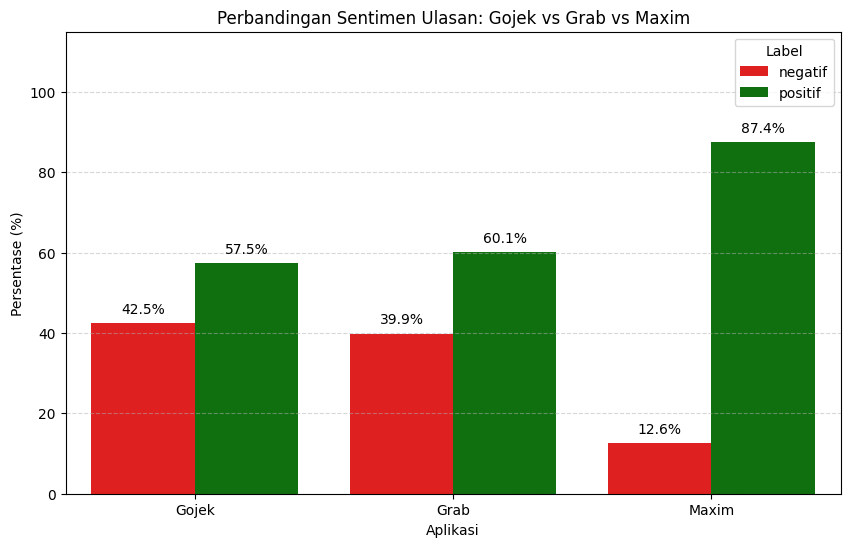

In [ ]:
sentiment_counts = df_all.groupby(['Aplikasi', 'Label']).size().reset_index(name='Counts')
total_counts = df_all.groupby('Aplikasi')['Label'].count().reset_index(name='Total')
sentiment_pct = pd.merge(sentiment_counts, total_counts, on='Aplikasi')
sentiment_pct['Percentage'] = (sentiment_pct['Counts'] / sentiment_pct['Total']) * 100

plt.figure(figsize=(10, 6))


palette_dict = {'positif': 'green', 'negatif': 'red'}

ax = sns.barplot(data=sentiment_pct, x='Aplikasi', y='Percentage', hue='Label', palette=palette_dict)
plt.title('Perbandingan Sentimen Ulasan: Gojek vs Grab vs Maxim')
plt.ylabel('Persentase (%)')
plt.ylim(0, 115)

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('grafik_sentimen.png', dpi=300)

**1. Maxim unggul signifikan dalam sentimen positif**

*   87,4% ulasan bersentimen positif dan hanya 12,6% negatif.
*   Menunjukkan kepuasan pengguna Maxim paling tinggi dibanding Grab dan Gojek.
*   Bisa diasumsikan faktor seperti harga murah, kemudahan akses, atau ekspektasi pengguna yang lebih rendah namun terpenuhi.

**2. Gojek dan Grab memiliki pola sentimen yang relatif mirip**

*   Gojek: 58% positif – 42% negatif
*   Grab: 60,3% positif – 39,7% negatif
*   Hampir 4 dari 10 pengguna masih menyampaikan keluhan.
*   Menandakan bahwa meskipun kedua aplikasi besar dan matang, ekspektasi pengguna tinggi sehingga mudah muncul sentimen negatif.

**3. Grab sedikit lebih baik dibanding Gojek**

*   Grab memiliki persentase positif tertinggi di antara dua market leader.
*   Bisa menjadi indikator bahwa layanan atau pengalaman pengguna Grab sedikit lebih konsisten menurut ulasan.

##WordCloud Gojek, Grab dan Maxim per Sentimen

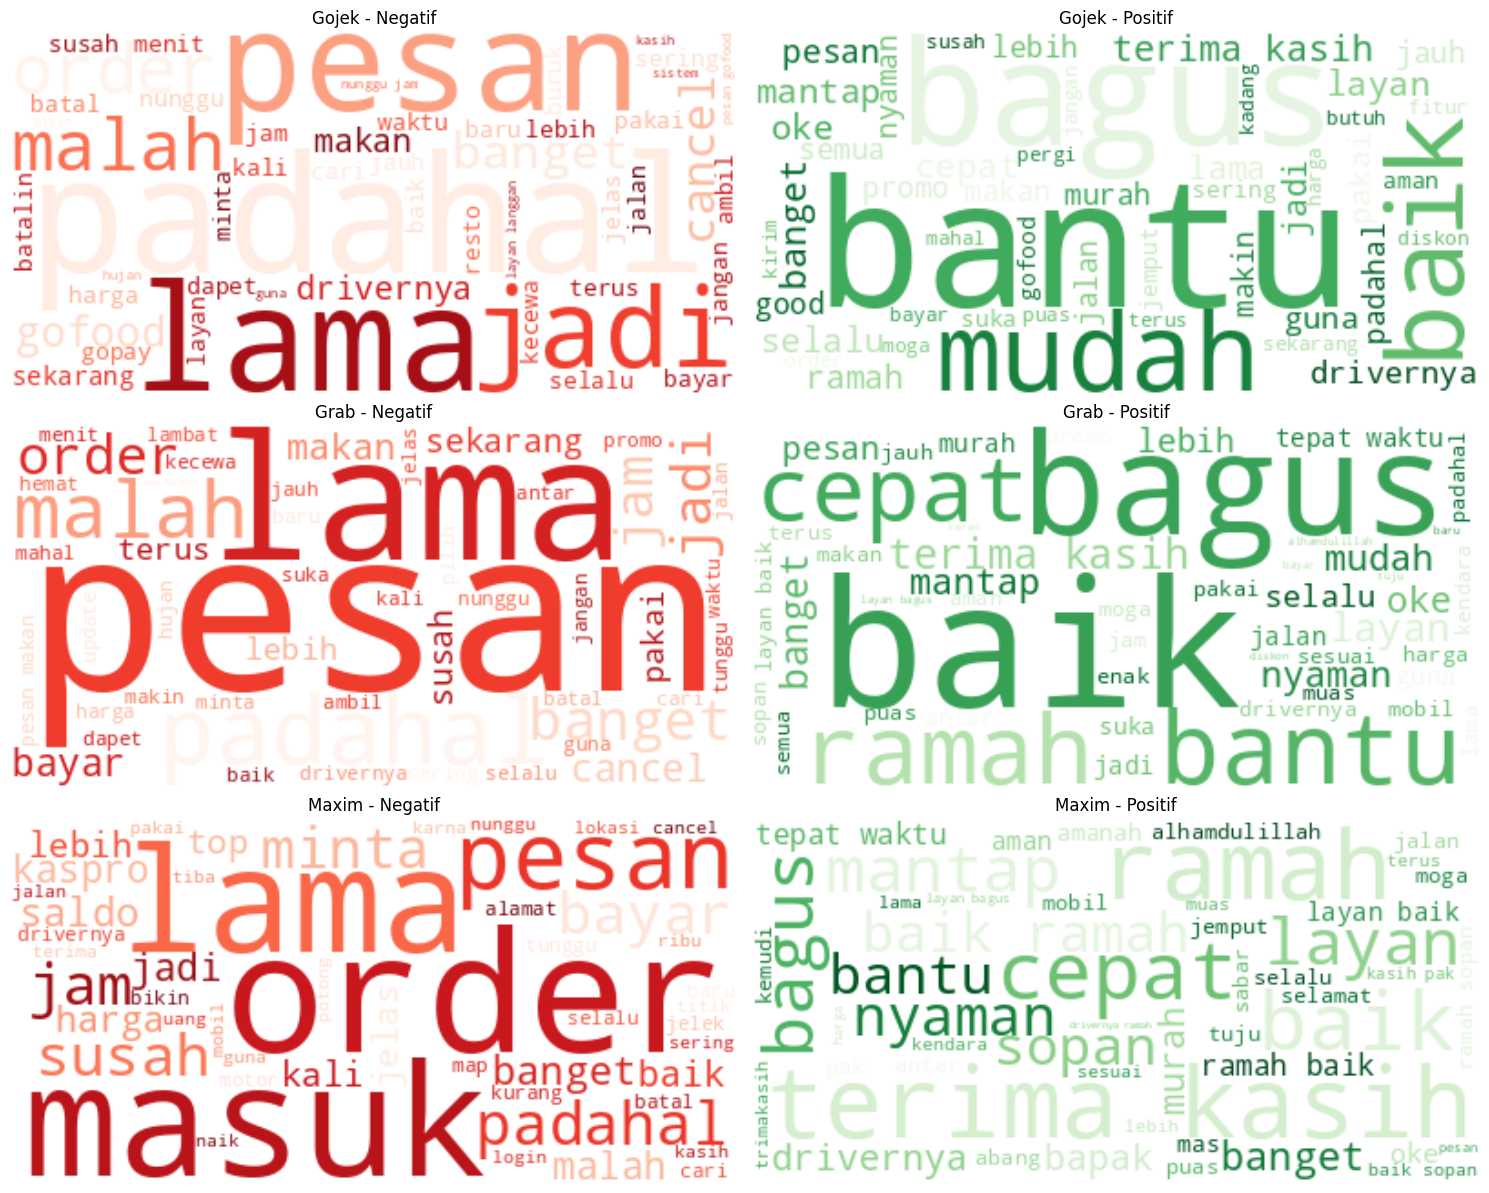

In [ ]:

apps = ['Gojek', 'Grab', 'Maxim']
sentiments = ['negatif', 'positif']
colormap_dict = {'negatif': 'Reds', 'positif': 'Greens'}

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for i, app in enumerate(apps):
    for j, sentiment in enumerate(sentiments):
        text_data = df_all[(df_all['Aplikasi'] == app) & (df_all['Label'] == sentiment)]['final_text']

        if len(text_data) > 0:
            text_combined = " ".join(text_data.astype(str))

            custom_stopwords = set(['gojek', 'grab', 'maxim', 'aplikasi', 'nya', 'yg', 'driver', 'orang', 'customer', 'tolong', 'di', 'dan', 'ini', 'itu'])

            wc = WordCloud(width=400, height=200,
                           background_color='white',
                           colormap=colormap_dict[sentiment],
                           stopwords=custom_stopwords,
                           max_words=50).generate(text_combined)
            axes[i, j].imshow(wc, interpolation='bilinear')
        else:
            axes[i, j].text(0.5, 0.5, "No Data", ha='center', va='center')

        axes[i, j].set_title(f"{app} - {sentiment.capitalize()}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('real_wordcloud_comparison.png')

**1. Sentimen negatif Gojek dan Grab didominasi permasalahan operasional**

*   Kata-kata seperti *pesan, order, cancel*, dan *lama* muncul paling dominan.
*   Hal ini menunjukkan bahwa keluhan pengguna banyak berkaitan dengan proses pemesanan, pembatalan layanan, dan waktu tunggu.
*   Pola ini mengindikasikan bahwa aspek keandalan layanan masih menjadi tantangan utama pada kedua aplikasi.

**2. Sentimen negatif Maxim relatif lebih terbatas**

*   Wordcloud negatif Maxim tetap memunculkan kata order dan *lama*, namun dengan variasi yang lebih sedikit.
*   Hal ini menunjukkan bahwa keluhan pengguna pada Maxim cenderung lebih terfokus dan tidak terlalu beragam dibandingkan Gojek dan Grab.

**3. Sentimen positif ketiga aplikasi menekankan kualitas layanan dan sikap driver**

*   Kata-kata seperti *ramah, baik, cepat, mudah,* dan *nyaman* mendominasi wordcloud positif.
*   Pada Maxim, kata-kata positif tersebut muncul lebih kuat dan konsisten.
*   Hal ini mengindikasikan bahwa keramahan driver dan kenyamanan layanan menjadi faktor utama kepuasan pengguna, khususnya pada Maxim.


Proporsi Distribusi Sentimen per Aplikasi

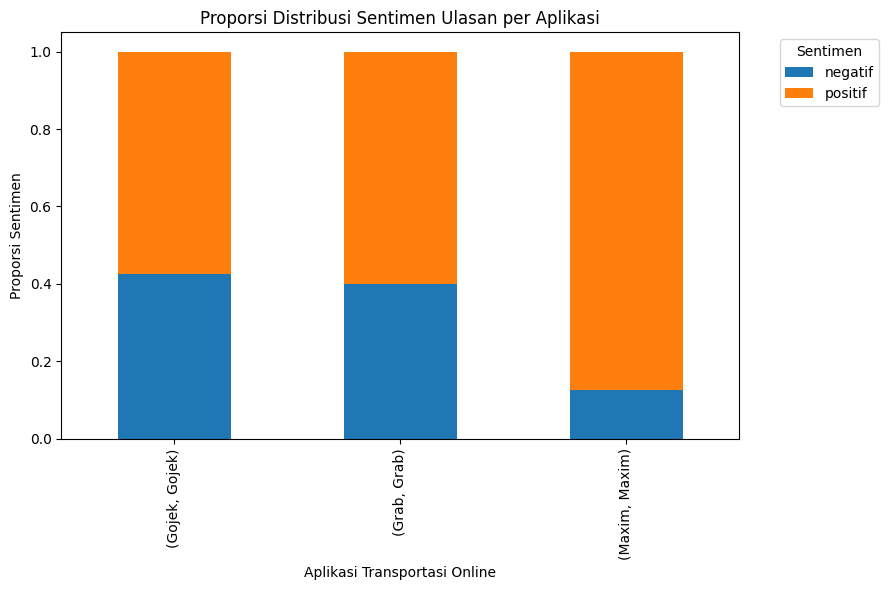

In [ ]:
pivot_sentimen = (
    df_all
    .groupby(['Aplikasi', 'Label'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(level='Label')
)

pivot_sentimen.plot(
    kind='bar',
    stacked=True,
    figsize=(9,6)
)

plt.title("Proporsi Distribusi Sentimen Ulasan per Aplikasi")
plt.xlabel("Aplikasi Transportasi Online")
plt.ylabel("Proporsi Sentimen")
plt.legend(title="Sentimen", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

##Confusion Matrix SVM

<Figure size 500x400 with 0 Axes>

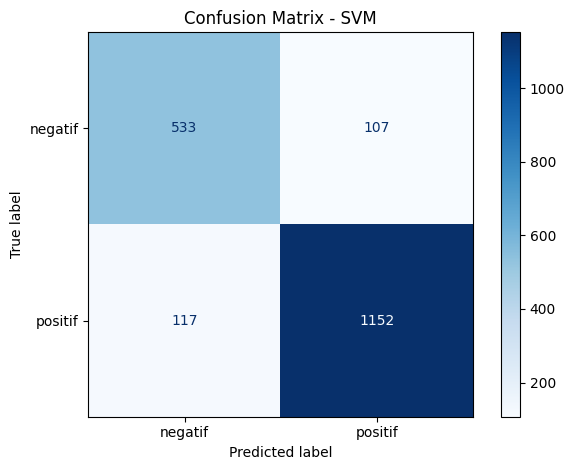

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=['negatif', 'positif']
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.show()

##TOP Kata per Sentimen Semua Aplikasi

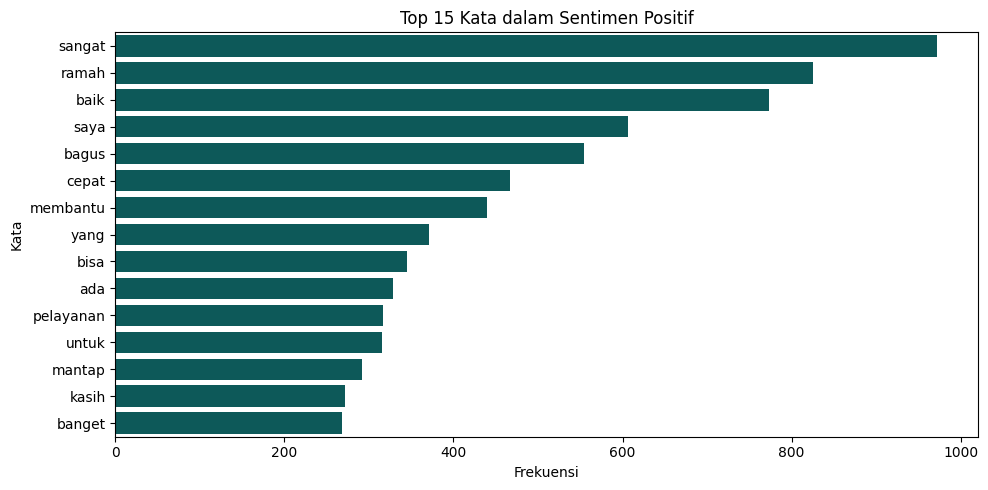

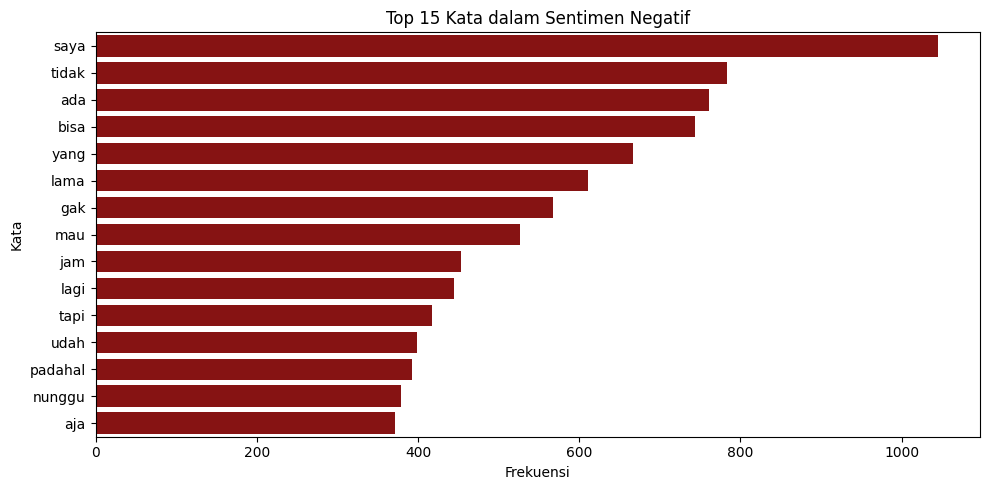

In [ ]:
sentiment_colors = {
    'positif': '#006666',
    'negatif': '#990000'
}

# Define the desired order of sentiments
desired_sentiment_order = ['positif', 'negatif']

for Sentiment in desired_sentiment_order:
    texts = df_all[df_all['Label'] == Sentiment]['Case_Folding']
    texts = texts.dropna().astype(str)

    if len(texts) == 0:
        continue

    all_words = ' '.join(texts).split()

    filtered_words = [
        word for word in all_words
        if word.lower() not in custom_stopwords and len(word) > 2
    ]

    if len(filtered_words) == 0:
        continue

    word_freq = Counter(filtered_words).most_common(15)
    word_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])

    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=word_df,
        x='frequency',
        y='word',
        color=sentiment_colors[Sentiment]
    )
    plt.title(f'Top 15 Kata dalam Sentimen {Sentiment.capitalize()}')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.tight_layout()
    plt.show()

**1. Sentimen negatif didominasi oleh ekspresi ketidakpuasan terhadap layanan**

*   Kata-kata seperti *tidak, gak, lama, jam,* dan *padahal*  muncul dengan frekuensi tinggi.
*   HMenunjukkan bahwa ketidakpuasan pengguna banyak berkaitan dengan layanan yang tidak berjalan sesuai harapan, terutama terkait waktu layanan dan hambatan dalam proses penggunaan aplikasi.

**2. Sentimen positif menekankan kualitas layanan dan interaksi pengguna**

*   Kata-kata seperti *sangat, ramah, baik, bagus, cepat,* dan *membantu* mendominasi sentimen positif.
*   Mengindikasikan bahwa kepuasan pengguna dipengaruhi oleh keramahan, kecepatan, dan kualitas pelayanan.
*   Terdapat kontras yang jelas antara karakteristik sentimen negatif dan positif.

**3. Sentimen negatif lebih berfokus pada kendala dan kegagalan layanan.**

*   Sentimen positif lebih menyoroti pengalaman layanan yang memuaskan dan interaksi yang baik.
*   Menunjukkan bahwa perbaikan pada aspek operasional berpotensi mengurangi sentimen negatif secara signifikan.

##Distribusi Rating Bintang(1-5) per Aplikasi

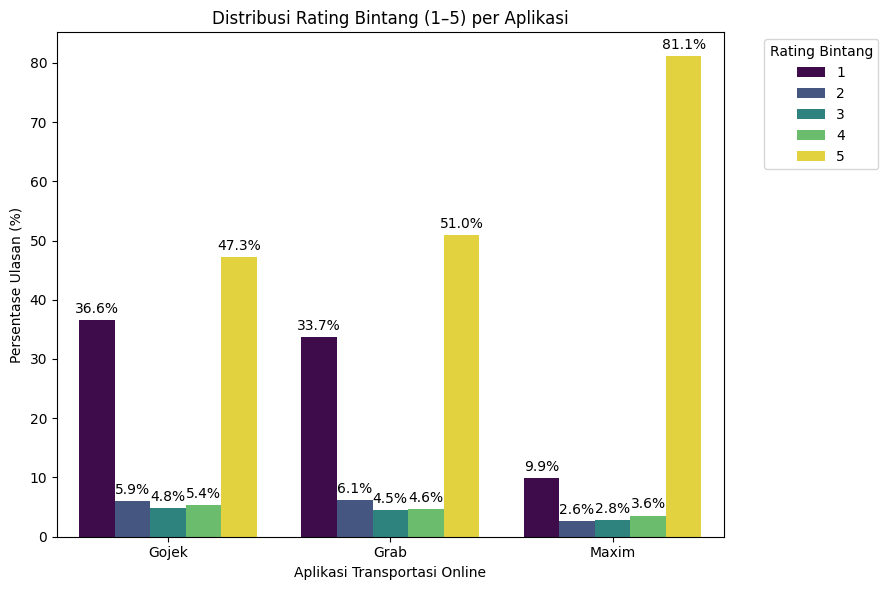

In [ ]:
rating_counts = df_all.groupby(['Aplikasi', 'Rating']).size().reset_index(name='Counts')
total_ratings = df_all.groupby('Aplikasi').size().reset_index(name='Total')
rating_percent = pd.merge(rating_counts, total_ratings, on='Aplikasi')
rating_percent['Persentase'] = (rating_percent['Counts'] / rating_percent['Total']) * 100

plt.figure(figsize=(9,6))
ax = sns.barplot(
    data=rating_percent,
    x='Aplikasi',
    y='Persentase',
    hue='Rating',
    palette='viridis'
)

plt.title("Distribusi Rating Bintang (1–5) per Aplikasi")
plt.xlabel("Aplikasi Transportasi Online")
plt.ylabel("Persentase Ulasan (%)")
plt.legend(title="Rating Bintang", bbox_to_anchor=(1.05, 1))

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

**1. Maxim unggul signifikan dalam rating tertinggi**


*  81,2% ulasan memberikan rating 5 bintang.
*  Proporsi rating rendah (1–2 bintang) relatif kecil.
*  Menunjukkan tingkat kepuasan pengguna Maxim yang sangat tinggi dan konsisten.

**2. Gojek dan Grab memiliki pola distribusi rating yang mirip**

*  Gojek: 48,0% rating 5 bintang, namun 36,1% rating 1 bintang.
*  Grab: 51,0% rating 5 bintang, dengan 33,6% rating 1 bintang.
*  Artinya, terdapat kesenjangan pengalaman pengguna, di mana sebagian sangat puas, namun sebagian lainnya sangat tidak puas.

**3. Grab sedikit lebih baik dibanding Gojek**


*  Grab memiliki persentase rating 5 bintang lebih tinggi dan rating 1 bintang lebih rendah dibanding Gojek.
*  Mengindikasikan bahwa pengalaman layanan Grab cenderung sedikit lebih stabil menurut penilaian pengguna.






##Distribusi Aspek Layanan

In [ ]:
aspek_dict = {
    'Harga': ['harga', 'mahal', 'murah', 'tarif', 'ongkos'],
    'Driver': ['driver', 'pengemudi', 'kurir'],
    'Aplikasi': ['aplikasi', 'app', 'error', 'bug', 'sistem'],
    'Waktu Tunggu': ['lama', 'nunggu', 'telat', 'lambat', 'menunggu'],
    'Customer Service': ['cs', 'customer service', 'layanan pelanggan', 'admin']
}

In [ ]:
def ekstrak_aspek(teks):
    aspek_ditemukan = []
    for aspek, keywords in aspek_dict.items():
        for kata in keywords:
            if kata in teks:
                aspek_ditemukan.append(aspek)
                break
    return aspek_ditemukan

df_all['Aspek'] = df_all['Case_Folding'].apply(ekstrak_aspek)

df_aspek = df_all.explode('Aspek')
df_aspek = df_aspek.dropna(subset=['Aspek'])

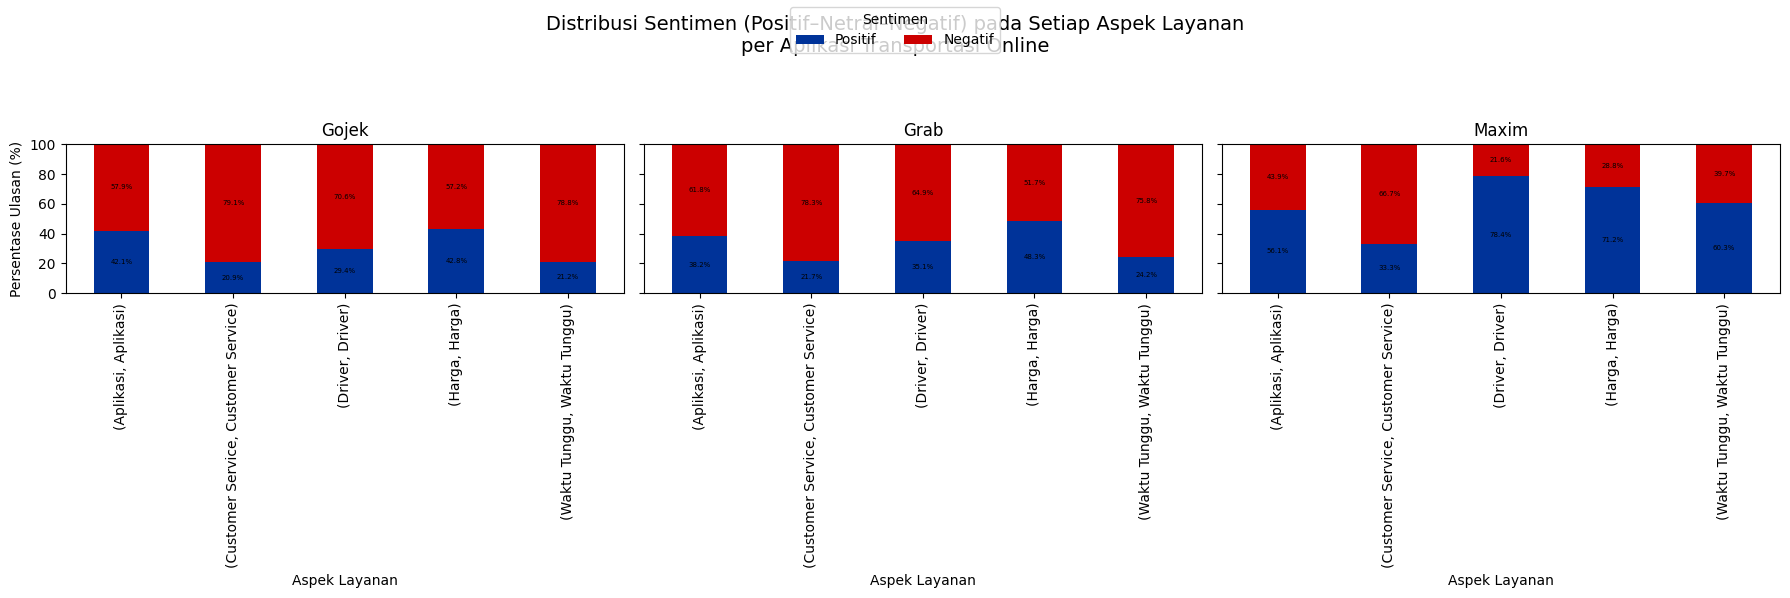

In [ ]:
sentimen_order = ['positif', 'negatif']
warna_sentimen = {
    'positif': '#003399',
    'negatif': '#CC0000'
}

aplikasi_list = ['Gojek', 'Grab', 'Maxim']

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, app in zip(axes, aplikasi_list):

    aspek_sentimen_app = (
        df_aspek[df_aspek['Aplikasi'] == app]
        .groupby(['Aspek', 'Label'])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum() * 100)
        .unstack('Label')
    )

    aspek_sentimen_app = aspek_sentimen_app[sentimen_order]

    aspek_sentimen_app.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=False,
        color=[warna_sentimen[s] for s in sentimen_order]
    )

    ax.set_title(app)
    ax.set_xlabel("Aspek Layanan")
    ax.set_ylim(0, 100)

    for container in ax.containers:
        labels = [
            f'{v:.1f}%' if v >= 5 else ''
            for v in container.datavalues
        ]
        ax.bar_label(
            container,
            labels=labels,
            label_type='center',
            fontsize=5
        )

axes[0].set_ylabel("Persentase Ulasan (%)")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    ['Positif', 'Negatif'],
    title="Sentimen",
    loc='upper center',
    ncol=3
)

fig.suptitle(
    "Distribusi Sentimen (Positif–Netral–Negatif) pada Setiap Aspek Layanan\nper Aplikasi Transportasi Online",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

**1. Aplikasi**

*   Gojek dan Grab masih didominasi sentimen negatif pada aspek aplikasi, menunjukkan adanya kendala terkait stabilitas sistem, fitur, atau kemudahan penggunaan.
*   Maxim menunjukkan proporsi sentimen positif yang lebih tinggi, mengindikasikan bahwa pengalaman penggunaan aplikasi dinilai lebih sederhana dan memadai oleh pengguna.

**2. Customer Service**

*   Aspek Customer Service menjadi aspek dengan sentimen negatif tertinggi pada Gojek dan Grab.
*   Hal ini mengindikasikan bahwa respon yang lambat, solusi yang kurang efektif, atau proses penanganan keluhan yang tidak memuaskan masih menjadi permasalahan utama.
*   Maxim memiliki sentimen positif yang lebih seimbang, menunjukkan layanan pelanggan yang relatif lebih diterima oleh pengguna.

**3. Driver**

*   Pada Gojek dan Grab, sentimen negatif masih mendominasi aspek Driver, menandakan adanya keluhan terkait sikap, profesionalisme, atau ketepatan layanan driver.
*   Sebaliknya, Maxim menunjukkan dominasi sentimen positif yang kuat pada aspek Driver, yang mengindikasikan bahwa keramahan dan perilaku driver menjadi keunggulan utama Maxim.

**4. Harga**

*   Ketiga aplikasi menunjukkan proporsi sentimen positif yang relatif lebih tinggi pada aspek Harga dibanding aspek lainnya.
*   Maxim unggul dengan dominasi sentimen positif yang signifikan, menunjukkan bahwa harga yang terjangkau menjadi faktor penting kepuasan pengguna.
*   Gojek dan Grab masih menerima sentimen negatif, yang kemungkinan berkaitan dengan tarif dinamis atau persepsi harga yang tidak konsisten.

**5. Waktu Tunggu**

*   Gojek dan Grab didominasi sentimen negatif pada aspek Waktu Tunggu, mengindikasikan bahwa keterlambatan penjemputan dan lamanya proses layanan masih menjadi keluhan utama pengguna.
*   Maxim memiliki proporsi sentimen positif yang lebih besar, menunjukkan bahwa kecepatan layanan relatif lebih baik dibandingkan kompetitor.

Heatmap Distribusi Aspek Layanan

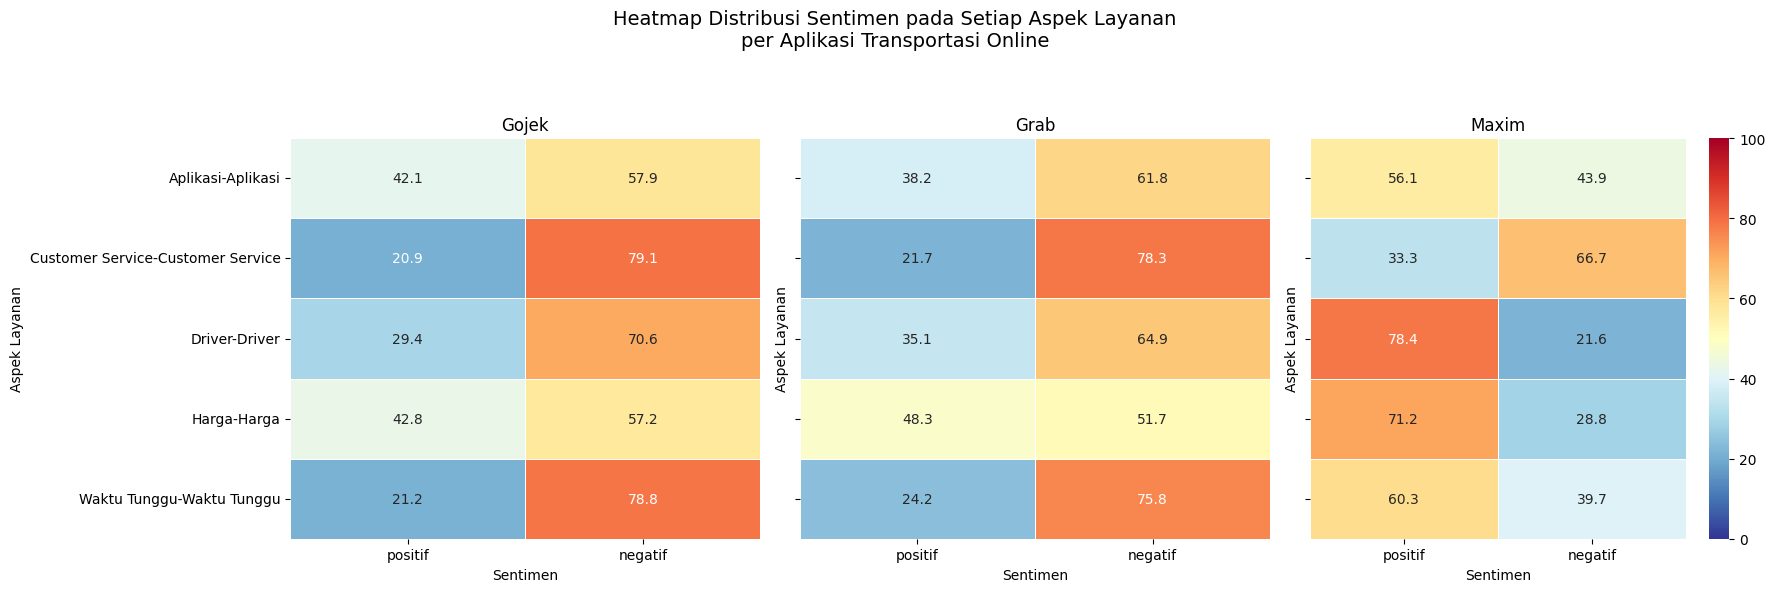

In [ ]:
sentimen_order = ['positif', 'negatif']
aplikasi_list = ['Gojek', 'Grab', 'Maxim']

fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, app in zip(axes, aplikasi_list):

    # Hitung persentase sentimen per aspek
    aspek_sentimen_app = (
        df_aspek[df_aspek['Aplikasi'] == app]
        .groupby(['Aspek', 'Label'])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum() * 100)
        .unstack('Label')
    )

    aspek_sentimen_app = aspek_sentimen_app[sentimen_order]

    # Heatmap
    sns.heatmap(
        aspek_sentimen_app,
        annot=True,
        fmt=".1f",
        cmap="RdYlBu_r",
        vmin=0,
        vmax=100,
        linewidths=0.5,
        ax=ax,
        cbar=ax == axes[-1]   # colorbar cuma sekali
    )

    ax.set_title(app)
    ax.set_xlabel("Sentimen")
    ax.set_ylabel("Aspek Layanan")

fig.suptitle(
    "Heatmap Distribusi Sentimen pada Setiap Aspek Layanan\nper Aplikasi Transportasi Online",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

#KESIMPULAN

**1. Maxim menunjukkan tingkat kepuasan pengguna tertinggi secara konsisten**

*   Dominasi sentimen positif (±87%), rating 5 bintang yang sangat tinggi (81,2%), serta persepsi positif pada hampir seluruh aspek layanan.
*   Keunggulan utama Maxim terletak pada kinerja driver, harga yang dianggap terjangkau, dan waktu layanan yang relatif cepat.
*   Hal ini menunjukkan bahwa Maxim berhasil memenuhi ekspektasi pengguna secara lebih stabil dibandingkan kompetitor.

**2. Gojek dan Grab**

*   Meskipun mayoritas ulasan bersentimen positif, proporsi sentimen negatif dan rating 1 bintang masih cukup tinggi.
*   Keluhan utama berulang pada aspek Customer Service, Waktu Tunggu, serta proses pemesanan dan pembatalan.
*   Pola ini mengindikasikan adanya ketimpangan pengalaman pengguna, di mana sebagian pengguna sangat puas, namun sebagian lainnya sangat tidak puas.

**3.  Aspek menjadi point utama**

*   Customer Service dan Waktu Tunggu, kedua aspek ini menunjukkan dominasi sentimen negatif pada hampir seluruh aplikasi, terutama Gojek dan Grab.
*   Hal ini menandakan bahwa kecepatan respon, efektivitas penanganan keluhan, dan ketepatan layanan masih menjadi area krusial yang perlu ditingkatkan.

**4. Faktor yang memengaruhi**

*   Berdasarkan Wordcloud dan top kata sentimen positif bahwa keramahan driver, kecepatan, dan sikap membantu menjadi faktor utama pembentuk persepsi positif.
*   Sebaliknya, keterlambatan dan layanan yang tidak sesuai ekspektasi menjadi pemicu utama sentimen negatif.







#REKOMENDASI

**🟢 Maxim**

*   Pertahankan keunggulan harga dan driver dengan menjaga skema tarif tetap kompetitif tanpa perubahan ekstrem.
*   Fokus pada stabilisasi kualitas layanan, terutama saat jam sibuk, agar kepuasan tetap konsisten.
*   Perbaikan bertahap Customer Service, misalnya mempercepat waktu respon keluhan.

**🟢 Gojek**

*   Prioritaskan perbaikan Customer Service pada kasus berulang, seperti pembatalan sepihak dan keterlambatan.
*   Tingkatkan kejelasan informasi di aplikasi (status order, estimasi waktu) untuk mengurangi keluhan pengguna.
*   Fokus pada peningkatan konsistensi layanan, bukan mengejar fitur baru.

**🟢 Grab**

*   Optimalkan manajemen waktu tunggu, khususnya pada area dan jam dengan volume tinggi.
*   Evaluasi kebijakan harga dan promo agar lebih sesuai dengan ekspektasi pengguna.
*   Perbaikan bertahap pada penanganan komplain sederhana agar tidak berujung pada ulasan negatif.